In [4]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchvision.models as models
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import os
from tqdm import tqdm

In [5]:
import kagglehub

# Download latest version
data = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", data)

Using Colab cache for faster access to the 'intel-image-classification' dataset.
Path to dataset files: /kaggle/input/intel-image-classification


In [6]:
import os

print(os.listdir(data))

"""
data/
 ├── 'seg_pred'
 └── 'seg_test'
 └── 'seg_train'
"""

['seg_train', 'seg_pred', 'seg_test']


"\ndata/\n ├── 'seg_pred'\n └── 'seg_test'\n └── 'seg_train'\n"

In [7]:
import torchvision.transforms as T

train_transform = T.Compose([
    T.Resize(232),                # сначала увеличиваем
    T.RandomCrop(224),            # случайный кроп для аугментации
    T.RandomHorizontalFlip(),     # аугментация
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    T.Resize(232),                # приводим к тому же размеру
    T.CenterCrop(224),            # фиксированный кроп
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# загружаем путь
train_dataset = datasets.ImageFolder(root=f"{data}/seg_train/seg_train", transform=train_transform)
test_dataset  = datasets.ImageFolder(root=f"{data}/seg_test/seg_test",   transform=test_transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Проверка
print("Классы:", train_dataset.classes)
print("Кол-во train:", len(train_dataset), "Кол-во test:", len(test_dataset))

Классы: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Кол-во train: 14034 Кол-во test: 3000


In [8]:
# Загружаем предобученную модель ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Меняем последний слой под количество классов (6 вместо 1000)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)

# Тест
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
"""
заморозка последнего слоя. Предобученная сеть уже умеет распозновать базовые паттерны. На новом датасете дотстчоно обучить на 1 слое,
чтобы модель научилась переводить прзнаки на новый класс + бысрее и экономит ресурсы
"""

# Настройка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используем устройство:", device)

# Заморозка всех слоёв модели
for param in model.parameters():
    param.requires_grad = False

# Замена последнего слоя
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6) # 6 классов
model = model.to(device)

# Оптимизатор и функция потерь
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Функция для вычисления accuracy
def accuracy(loader, model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Цикл обучения
num_epochs = 10
train_losses = []
test_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Эпоха {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Метрики
    train_acc = accuracy(train_loader, model)
    test_acc = accuracy(test_loader, model)
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    test_accs.append(test_acc)

    print(f"Эпоха [{epoch+1}/{num_epochs}] | "
          f"Loss: {avg_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

Используем устройство: cuda


Эпоха 1/10: 100%|██████████| 439/439 [01:38<00:00,  4.47it/s]


Эпоха [1/10] | Loss: 0.4908 | Train Acc: 0.9065 | Test Acc: 0.8940


Эпоха 2/10: 100%|██████████| 439/439 [00:55<00:00,  7.85it/s]


Эпоха [2/10] | Loss: 0.3090 | Train Acc: 0.9047 | Test Acc: 0.8950


Эпоха 3/10: 100%|██████████| 439/439 [00:55<00:00,  7.88it/s]


Эпоха [3/10] | Loss: 0.2857 | Train Acc: 0.9070 | Test Acc: 0.8973


Эпоха 4/10: 100%|██████████| 439/439 [00:56<00:00,  7.83it/s]


Эпоха [4/10] | Loss: 0.2770 | Train Acc: 0.9178 | Test Acc: 0.9010


Эпоха 5/10: 100%|██████████| 439/439 [00:56<00:00,  7.74it/s]


Эпоха [5/10] | Loss: 0.2699 | Train Acc: 0.9217 | Test Acc: 0.9103


Эпоха 6/10: 100%|██████████| 439/439 [00:56<00:00,  7.81it/s]


Эпоха [6/10] | Loss: 0.2636 | Train Acc: 0.9236 | Test Acc: 0.9103


Эпоха 7/10: 100%|██████████| 439/439 [00:56<00:00,  7.77it/s]


Эпоха [7/10] | Loss: 0.2652 | Train Acc: 0.9227 | Test Acc: 0.9120


Эпоха 8/10: 100%|██████████| 439/439 [00:56<00:00,  7.79it/s]


Эпоха [8/10] | Loss: 0.2550 | Train Acc: 0.9259 | Test Acc: 0.9120


Эпоха 9/10: 100%|██████████| 439/439 [00:56<00:00,  7.77it/s]


Эпоха [9/10] | Loss: 0.2539 | Train Acc: 0.9184 | Test Acc: 0.9047


Эпоха 10/10: 100%|██████████| 439/439 [00:56<00:00,  7.80it/s]


Эпоха [10/10] | Loss: 0.2492 | Train Acc: 0.9303 | Test Acc: 0.9150


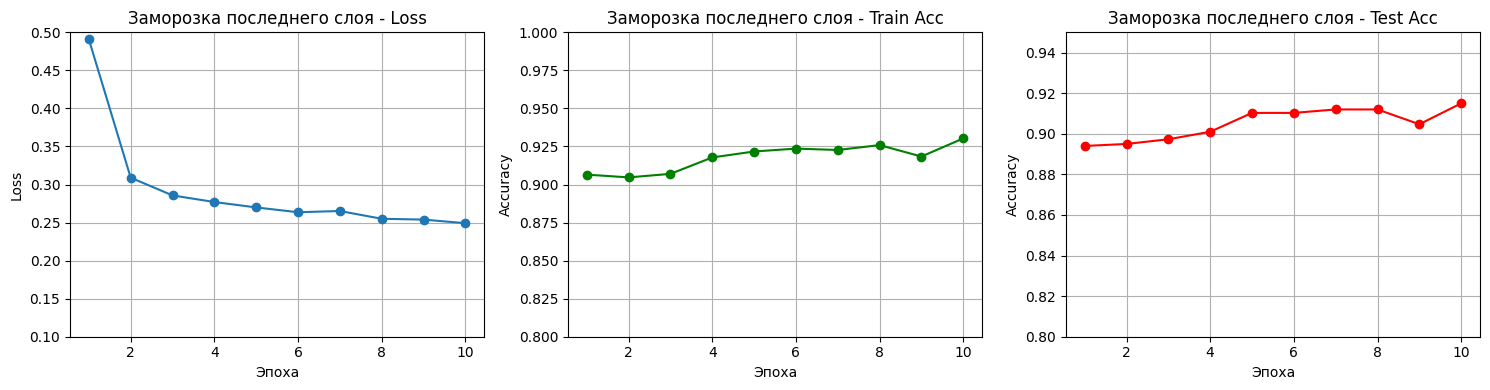

In [13]:
import matplotlib.pyplot as plt

# Данные
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Заморозка последнего слоя (новые данные)
loss_last = [0.4908, 0.3090, 0.2857, 0.2770, 0.2699, 0.2636, 0.2652, 0.2550, 0.2539, 0.2492]
train_acc_last = [0.9065, 0.9047, 0.9070, 0.9178, 0.9217, 0.9236, 0.9227, 0.9259, 0.9184, 0.9303]
test_acc_last = [0.8940, 0.8950, 0.8973, 0.9010, 0.9103, 0.9103, 0.9120, 0.9120, 0.9047, 0.9150]

experiments = [
    ("Заморозка последнего слоя", loss_last, train_acc_last, test_acc_last),
]

# Построение графиков
for name, loss, train_acc, test_acc in experiments:
    plt.figure(figsize=(15,4))

    plt.subplot(1,3,1)
    plt.plot(epochs, loss, marker='o')
    plt.title(f'{name} - Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.ylim(0.1, 0.5)
    plt.grid(True)

    plt.subplot(1,3,2)
    plt.plot(epochs, train_acc, marker='o', color='green')
    plt.title(f'{name} - Train Acc')
    plt.xlabel('Эпоха')
    plt.ylabel('Accuracy')
    plt.ylim(0.8, 1)
    plt.grid(True)

    plt.subplot(1,3,3)
    plt.plot(epochs, test_acc, marker='o', color='red')
    plt.title(f'{name} - Test Acc')
    plt.xlabel('Эпоха')
    plt.ylabel('Accuracy')

    plt.grid(True)
    plt.ylim(0.8, 0.95)
    plt.tight_layout()
    plt.show()

In [15]:
from PIL import Image
import requests
from io import BytesIO
import torch.nn.functional as F
import torchvision.transforms.functional as TF

# Ссылка на изображение
url = "https://i.pinimg.com/474x/e6/3e/c8/e63ec8e0231fcaba764b1b96c8046872.jpg?nii=t"

# Загружаем изображение
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")

# Преобразования для ResNet18
img = TF.resize(img, [224, 224])
img = TF.to_tensor(img)
img = TF.normalize(img, mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])

# Добавляем размер батча
img = img.unsqueeze(0).to(device)

# Прогон через модель
model.eval()
with torch.no_grad():
    outputs = model(img)
    probs = F.softmax(outputs, dim=1)  # тут F из torch.nn.functional
    pred_class = torch.argmax(probs, dim=1).item()
    prob = probs[0, pred_class].item()

print(f"Predicted: {train_dataset.classes[pred_class]} (prob={prob:.3f})")

Predicted: sea (prob=0.988)
